# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we trained an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

In [13]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import json
import os, random
from PIL import Image
import matplotlib.pyplot as plt 
from collections import OrderedDict
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import torchvision
import numpy as np

## Load the data

Here we used `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)).The dataset is split into three parts, training, validation, and testing. For the training, we applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we resized then cropped the images to the appropriate size.

The pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [9]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [10]:
#Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(35),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                     ])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
# Using the image datasets and the transforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)


### Label mapping

We also need to load in a mapping from category label to category name which was stored in a local json file.

In [11]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

### Checking how the data looks

tensor(1)


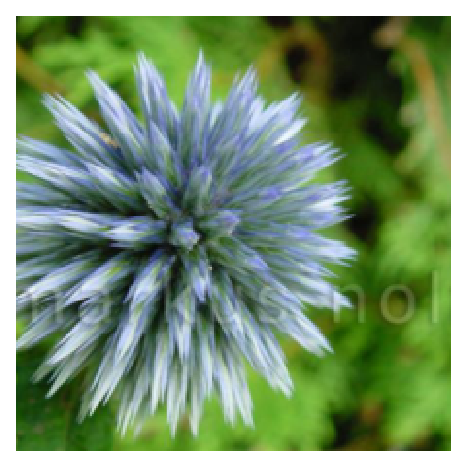

In [12]:
images, labels = next(iter(validloader))
imshow(images[10], normalize=True)
print(labels[10])

In [13]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we whould use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We would do the following:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [14]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg19(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
#Defining the classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('drop', nn.Dropout(p=0.5)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

model.to(device);

In [15]:
epochs = 8
steps = 0
running_loss = 0
print_every = 15
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        #Moving labels and input to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/8.. Train loss: 4.485.. Validation loss: 4.240.. Validation accuracy: 0.079
Epoch 1/8.. Train loss: 4.260.. Validation loss: 3.907.. Validation accuracy: 0.170
Epoch 1/8.. Train loss: 4.060.. Validation loss: 3.659.. Validation accuracy: 0.221
Epoch 1/8.. Train loss: 3.845.. Validation loss: 3.354.. Validation accuracy: 0.280
Epoch 1/8.. Train loss: 3.562.. Validation loss: 3.099.. Validation accuracy: 0.311
Epoch 1/8.. Train loss: 3.410.. Validation loss: 2.829.. Validation accuracy: 0.407
Epoch 2/8.. Train loss: 3.280.. Validation loss: 2.643.. Validation accuracy: 0.415
Epoch 2/8.. Train loss: 3.047.. Validation loss: 2.450.. Validation accuracy: 0.458
Epoch 2/8.. Train loss: 2.835.. Validation loss: 2.263.. Validation accuracy: 0.512
Epoch 2/8.. Train loss: 2.824.. Validation loss: 2.117.. Validation accuracy: 0.556
Epoch 2/8.. Train loss: 2.608.. Validation loss: 1.989.. Validation accuracy: 0.565
Epoch 2/8.. Train loss: 2.589.. Validation loss: 1.834.. Validation accuracy

## Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
test_loss = 0
accuracy = 0
with torch.no_grad():
    model.eval()
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        print(f"Test accuracy: {accuracy/len(testloader):.3f}")
        

Test accuracy: 0.062
Test accuracy: 0.126
Test accuracy: 0.188
Test accuracy: 0.243
Test accuracy: 0.311
Test accuracy: 0.370
Test accuracy: 0.444
Test accuracy: 0.504
Test accuracy: 0.577
Test accuracy: 0.650
Test accuracy: 0.710
Test accuracy: 0.772
Test accuracy: 0.835


## Save the checkpoint

Now that our network is trained, save the model so we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which makes inference easier later on.

In [17]:
model.class_to_idx  = train_data.class_to_idx

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [18]:
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'arch': 'vgg19',
              'learning_rate': 0.01,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer_state': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

In [19]:
torch.save(checkpoint, 'checkpoint.pth')

In [6]:
#Write a function that loads a checkpoint and rebuilds the model 
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    return model, optimizer

In [7]:
trained_model,optimizer = load_checkpoint('checkpoint.pth') 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 98903635.13it/s] 


# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

We'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [8]:
def process_image(image_input):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    img = Image.open(image_input)
    img = img.resize((256,256))
    value_set = 12 #set value for adjusting 
    img = img.crop((value_set,value_set,256-value_set,256-value_set))
    img= np.array(img)/255
    img = (img - np.array([0.485, 0.456, 0.406]))/np.array([0.229, 0.224, 0.225])

    return img.transpose(2,0,1)

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [9]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

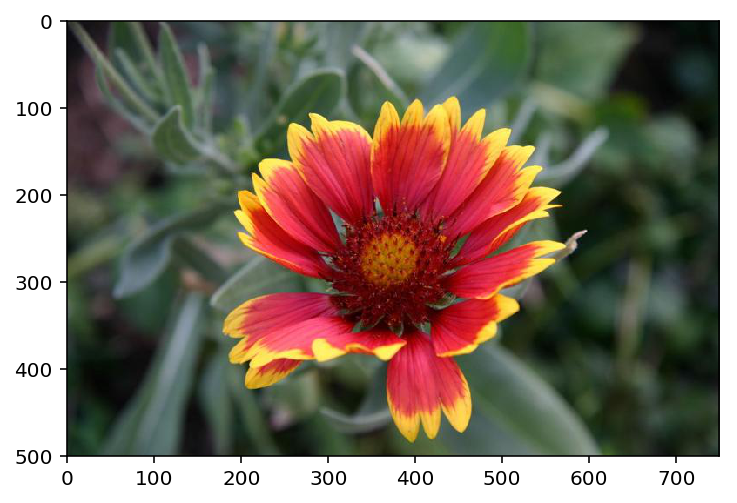

In [10]:
img_file = './flowers/test/100/' + random.choice(os.listdir('./flowers/test/100/'))

with Image.open(img_file) as image:
    plt.imshow(image)

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which hopefully we added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [11]:
def predict(image_path, model, topk=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    #Set to evaluation 
    model.eval()
    #process the image
    image = process_image(image_path)
    #Setting up the image as input
    image = Variable(torch.from_numpy(np.array([image])).float())    
    image = image.to(device)        
    output = model.forward(image)
    #Extract probabilities and labels
    probabilities = torch.exp(output).data
    probs = torch.topk(probabilities, topk)[0].tolist()[0]
    index = torch.topk(probabilities, topk)[1].tolist()[0]
    indx = []
    for ind in range(len(model.class_to_idx.items())):
        indx.append(list(model.class_to_idx.items())[ind][0])

    labels = []
    for i in range(5):
        labels.append(indx[index[i]])

    return probs, labels

Classes: ['2', '77', '78', '84', '102']
Probability: [0.9999580383300781, 9.849973139353096e-06, 4.693687969847815e-06, 4.448987056093756e-06, 3.671194008347811e-06]
Flowers:
['hard-leaved pocket orchid']
['passion flower']
['lotus lotus']
['columbine']
['blackberry lily']


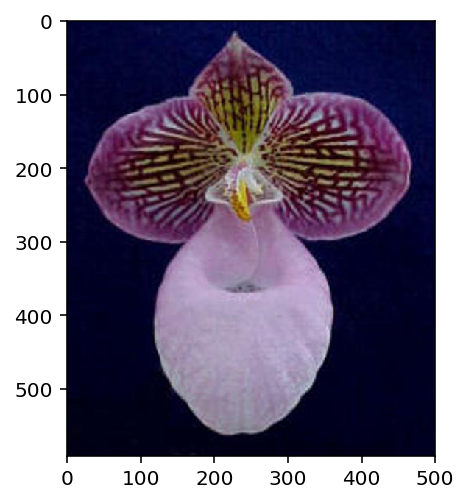

In [16]:
img_path = './flowers/test/2/' + random.choice(os.listdir('./flowers/test/2/'))
with  Image.open(img_path) as image:
    plt.imshow(image)
    
probabilities, classes = predict(img_path, trained_model)
print('Classes:',classes)
print('Probability:',probabilities)
print('Flowers:')
for cats in classes:
    print([cat_to_name[cats]])


## Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

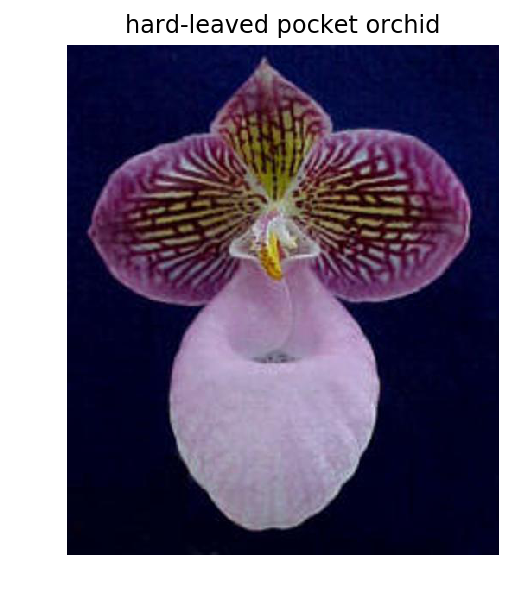

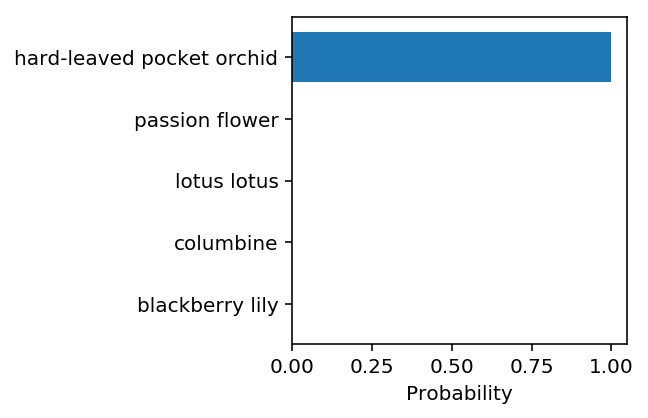

In [17]:
#Display an image along with the top 5 classes
probs, classes = predict(img_path, trained_model)
maxindex = np.argmax(probs)
maxprob = probs[maxindex]
label = classes[maxindex]

figr1 = plt.figure(figsize=(4,4),)
image = Image.open(img_path)
plt.imshow(image)
plt.title(cat_to_name[label])
plt.tight_layout(pad=0.01)
plt.axis('off')
figr2 = plt.figure(figsize=(3,3))
plt.barh(np.arange(5), probs)
plt.xlabel('Probability')
plt.gca().invert_yaxis()
labels = []
for a in classes:
     labels.append(cat_to_name[a])
plt.yticks(np.arange(5),labels)
plt.show()